### Dataset_Prep

In [5]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
import keras
from keras.metrics import MeanIoU
import random
import glob
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from patch_maker_utils import *
# from keras.applications.resnet50 import preprocess_input, decode_predictions
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess_input = keras.applications.resnet_v2.preprocess_input()

2.13.0
Samples per year: {'Training': {'2003': 40, '2004': 31, '2005': 7, '2006': 19, '2007': 14, '2008': 10, '2009': 33, '2010': 29, '2011': 3, '2013': 7, '2014': 9, '2015': 37, '2018': 112, '2019': 115, '2020': 116, '2021': 116}, 'Evaluation': {'2003': 11, '2004': 4, '2005': 2, '2006': 9, '2007': 4, '2008': 5, '2009': 7, '2010': 4, '2011': 3, '2013': 2, '2014': 4, '2015': 8, '2018': 41, '2019': 41, '2020': 41, '2021': 41}}


2024-03-25 02:16:39.019545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78791 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.
227


NameError: name 'keras' is not defined

In [2]:
train_imgs = np.load('data/train_img_64.npy')
train_msks = np.load('data/train_msk_64.npy')
val_imgs = np.load('data/val_img_64.npy')
val_msks = np.load('data/val_msk_64.npy')

# print(train_imgs.shape)
# train_imgs=np.append(train_imgs,val_imgs[500:-1,:,:,:]).reshape(-1,128, 128, 7)
# train_msks=np.append(train_msks,val_msks[500:-1,:,:,:]).reshape(-1,128, 128, 3)

# val_imgs=val_imgs[0:500,:,:,:]
# val_msks=val_msks[0:500,:,:,:]
# print(train_imgs.shape)
# print(len(train_imgs),len(val_imgs))

In [3]:
train_img_gen = trainGenerator(train_imgs,train_msks,batch_size=16,bands=3,target_size=(64, 64))
valid_img_gen = trainGenerator(val_imgs,val_msks,batch_size=16,eval_set=True,bands=3,target_size=(64, 64))

NameError: name 'trainGenerator' is not defined

In [ ]:
train_img_gen

In [8]:
valid_img_gen

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None))>

###### ResNet50V2

In [8]:
batch_size = 16

steps_per_epoch = len(train_imgs)//batch_size
val_steps_per_epoch = len(val_imgs)//batch_size
mIou = keras.metrics.OneHotMeanIoU(num_classes=3)
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_CHANNELS = 3
n_classes = 3

In [9]:
from keras.layers import Input, Conv2D
from keras.models import Model
BACKBONE = 'resnet50'
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                classes=n_classes, activation='softmax')

# inp = Input(shape=(None, None, 3))
# l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
# out = model(l1)

# model = Model(inp, out, name=model.name)

In [9]:
model.load_weights('/scratch/gza5dr/IrrigationTypeDetection/Experinments/proposed_experiment/model_ckpt/6_res50_16.keras')

In [14]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00000001)
checkpoint_filepath = 'model_ckpt/7_res50_16_64_7ch.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=.00004), loss=bce_dice_loss, 
                                              metrics=['accuracy','precision','recall',mIoU,
                                              f1_score,f1_score0,f1_score1,f1_score2,
                                              precision_0,precision_1,precision_2,recall_0,recall_1,recall_2])

In [21]:
# model.load_weights('model_ckpt/mres50_1.weights.h5')

In [16]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=2,
          validation_data=valid_img_gen,
          validation_steps=val_steps_per_epoch,callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/50


2024-03-25 00:38:36.529441: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564e624c9a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 00:38:36.529474: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-25 00:38:37.486104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-25 00:38:40.098390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-03-25 00:38:57.237332: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_347', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_239', 44 bytes spill stores, 44 bytes spill loads
ptxas wa

555/555 - 63s - 114ms/step - accuracy: 0.4355 - f1_score: 0.3521 - f1_score0: 0.3425 - f1_score1: 0.2845 - f1_score2: 0.4293 - loss: 1.2647 - m_io_u: 0.1856 - precision: 0.4945 - precision_0: 0.3797 - precision_1: 0.3497 - precision_2: 0.4017 - recall: 0.2154 - recall_0: 0.3643 - recall_1: 0.2886 - recall_2: 0.4847 - val_accuracy: 0.3756 - val_f1_score: 0.2096 - val_f1_score0: 0.0734 - val_f1_score1: 0.0222 - val_f1_score2: 0.5332 - val_loss: 4.1069 - val_m_io_u: 0.1370 - val_precision: 0.3757 - val_precision_0: 0.3718 - val_precision_1: 0.2466 - val_precision_2: 0.3767 - val_recall: 0.3738 - val_recall_0: 0.0424 - val_recall_1: 0.0125 - val_recall_2: 0.9423 - learning_rate: 4.0000e-05
Epoch 2/50


2024-03-25 00:39:39.092138: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_347', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_239', 44 bytes spill stores, 44 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_128', 52 bytes spill stores, 52 bytes spill loads



555/555 - 38s - 69ms/step - accuracy: 0.5275 - f1_score: 0.4129 - f1_score0: 0.3757 - f1_score1: 0.3642 - f1_score2: 0.4987 - loss: 1.1371 - m_io_u: 0.2191 - precision: 0.5793 - precision_0: 0.4086 - precision_1: 0.4151 - precision_2: 0.4855 - recall: 0.3830 - recall_0: 0.4056 - recall_1: 0.3913 - recall_2: 0.5370 - val_accuracy: 0.3005 - val_f1_score: 0.3228 - val_f1_score0: 0.3119 - val_f1_score1: 0.2173 - val_f1_score2: 0.4393 - val_loss: 1.4399 - val_m_io_u: 0.1725 - val_precision: 0.2866 - val_precision_0: 0.4588 - val_precision_1: 0.1588 - val_precision_2: 0.4418 - val_recall: 0.2065 - val_recall_0: 0.2362 - val_recall_1: 0.3441 - val_recall_2: 0.4368 - learning_rate: 4.0000e-05
Epoch 3/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


555/555 - 11s - 21ms/step - accuracy: 0.5750 - f1_score: 0.4562 - f1_score0: 0.4150 - f1_score1: 0.4102 - f1_score2: 0.5433 - loss: 1.0639 - m_io_u: 0.2416 - precision: 0.6158 - precision_0: 0.4467 - precision_1: 0.4540 - precision_2: 0.5357 - recall: 0.4834 - recall_0: 0.4499 - recall_1: 0.4494 - recall_2: 0.5770 - val_accuracy: 0.5534 - val_f1_score: 0.4410 - val_f1_score0: 0.3883 - val_f1_score1: 0.3599 - val_f1_score2: 0.5750 - val_loss: 1.1035 - val_m_io_u: 0.2436 - val_precision: 0.5847 - val_precision_0: 0.4441 - val_precision_1: 0.3889 - val_precision_2: 0.5499 - val_recall: 0.4741 - val_recall_0: 0.3796 - val_recall_1: 0.3971 - val_recall_2: 0.6143 - learning_rate: 4.0000e-05
Epoch 4/50
555/555 - 9s - 17ms/step - accuracy: 0.6077 - f1_score: 0.4883 - f1_score0: 0.4510 - f1_score1: 0.4482 - f1_score2: 0.5658 - loss: 1.0109 - m_io_u: 0.2570 - precision: 0.6448 - precision_0: 0.4788 - precision_1: 0.4871 - precision_2: 0.5615 - recall: 0.5356 - recall_0: 0.4919 - recall_1: 0.4967

In [10]:
model.load_weights('model_ckpt/mres50_1.weights.h5')

model.evaluate(valid_img_gen)

NameError: name 'valid_img_gen' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


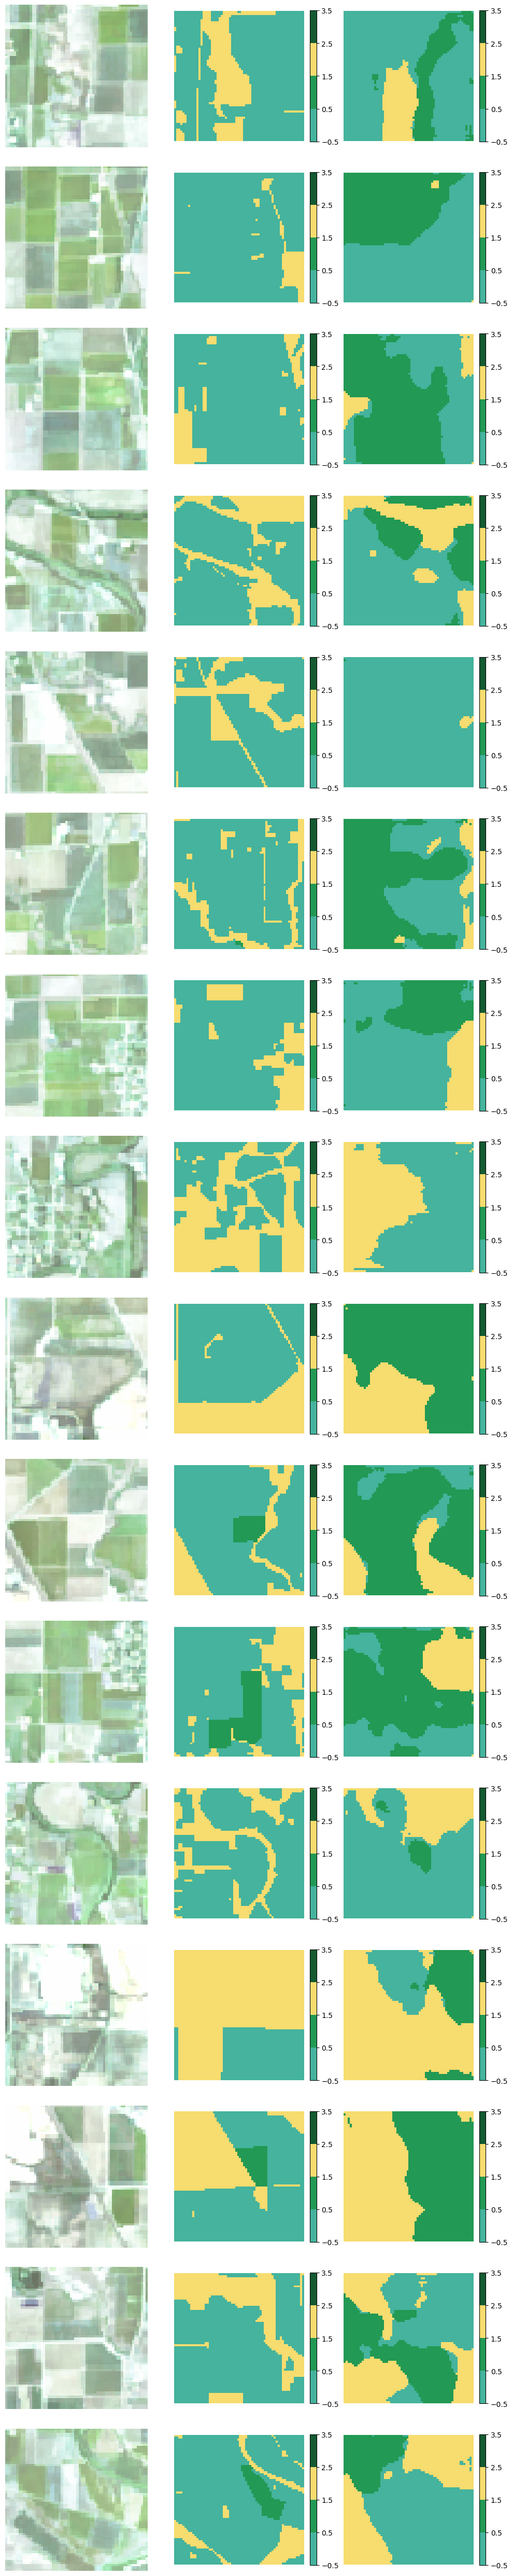

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
# Assuming model, valid_img_gen are defined, and weights are loaded
x = valid_img_gen.take(5)
fig, axs = plt.subplots(16, 3, figsize=(10, 50))
class_colors = ['#45B39D', '#229954', '#F7DC6F','#145A32']  # Example for 3 classes
custom_cmap = ListedColormap(class_colors)
class_labels = [0, 1, 2,3] 
boundaries = np.arange(min(class_labels) - 0.5, max(class_labels) + 1.5, 1)
norm = BoundaryNorm(boundaries, custom_cmap.N, clip=True)
class_names = ['Flood','Sprinkler','NonIrr']
cnt = 0
legend_handles = [Patch(color=color, label=label) for color, label in zip(class_colors, class_names)]
i=0

for images, labels in x:
    preds = model.predict(images)
    for i in range(16):
        image = images[i].numpy()
        label = labels[i].numpy()  # Adjusted for direct numpy conversion
        masks = np.argmax(label, axis=-1)
        pred_mask = np.argmax(preds[i], axis=-1)

        # Display the image
        im0 = axs[i][0].imshow(image[:,:,:3])
        # Display the true mask
        im1 = axs[i][1].imshow(masks,cmap=custom_cmap, norm=norm, interpolation='nearest')
        # Display the predicted mask
        im2 = axs[i][2].imshow(pred_mask,cmap=custom_cmap, norm=norm, interpolation='nearest')

        # Remove ticks
        axs[i][0].axis('off')
        axs[i][1].axis('off')
        axs[i][2].axis('off')

        # Add colorbars
        # For the true mask
        fig.colorbar(im1, ax=axs[i][1], fraction=0.046, pad=0.04)
        # For the predicted mask
        fig.colorbar(im2, ax=axs[i][2], fraction=0.046, pad=0.04)

    break  # Since you have a break here, it only goes through the loop once

plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


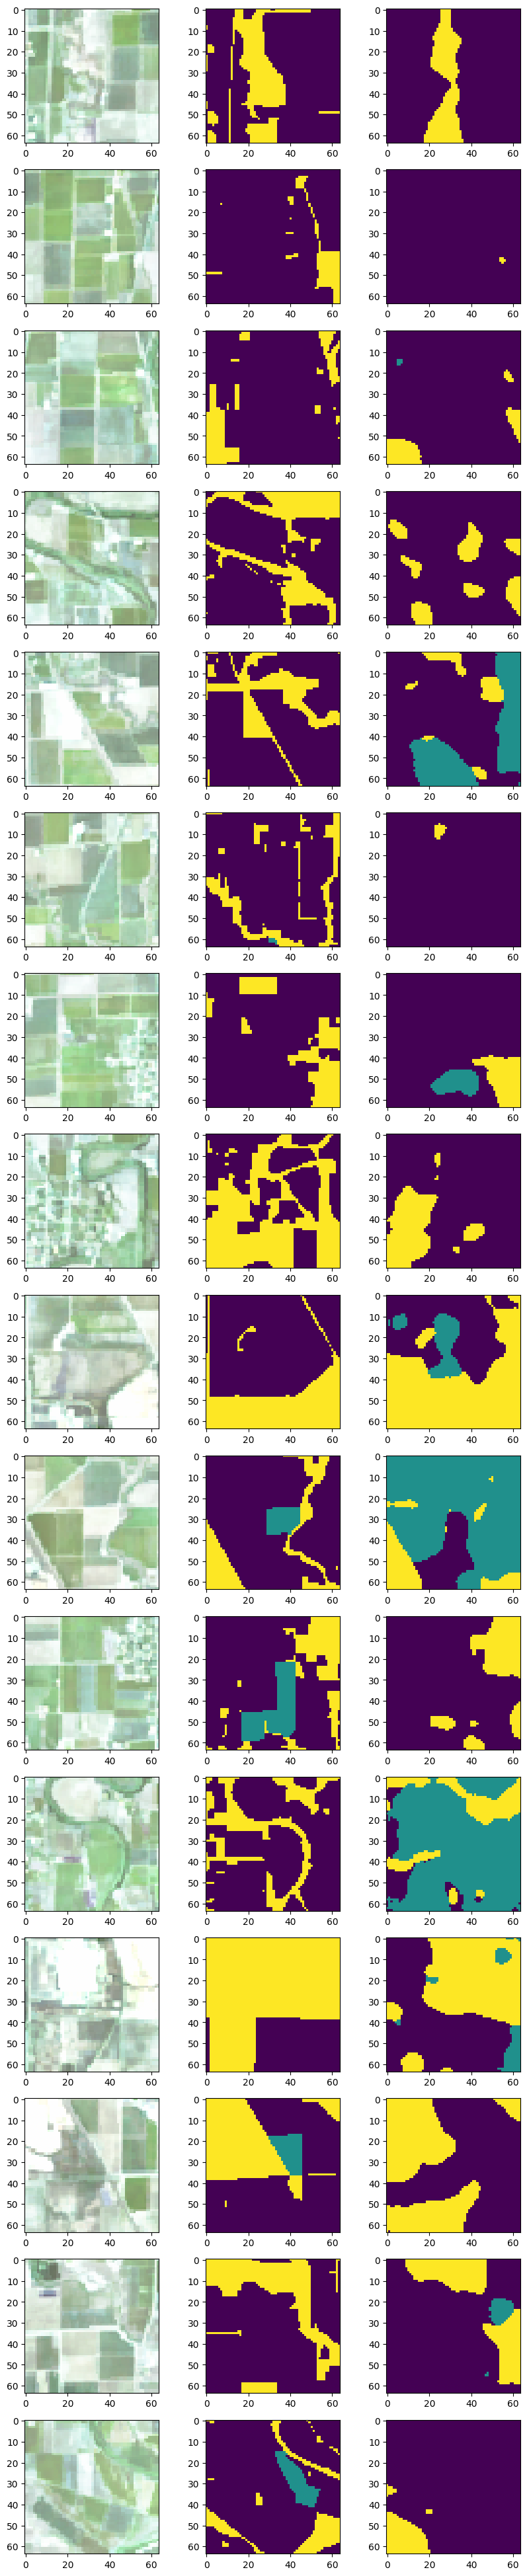

In [15]:
model.load_weights('model_ckpt/mres50_1.weights.h5')
x = valid_img_gen.take(1)
fig,axs = plt.subplots(16,3,figsize=(10, 50))
for images,labels in x:
    # print(images.shape)
    preds=model.predict(images)
    # print(np.array(preds).shape)
    for i in range(16):
        image = images[i].numpy()
        # image = cv2.normalize(image, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        print(labels[i].shape)
        masks = np.argmax(labels[i],axis=-1)
        pred_mask = np.argmax(preds[i],axis=-1)
        axs[i][0].imshow(image)
        axs[i][1].imshow(masks)
        axs[i][2].imshow(pred_mask)
    break

In [ ]:

train_img_gen = trainGenerator(train_imgs,train_msks,batch_size=16,bands=3,target_size=(64, 64))
valid_img_gen = trainGenerator(val_imgs,val_msks,batch_size=16,eval_set=True,bands=3,target_size=(64, 64))

### Extra

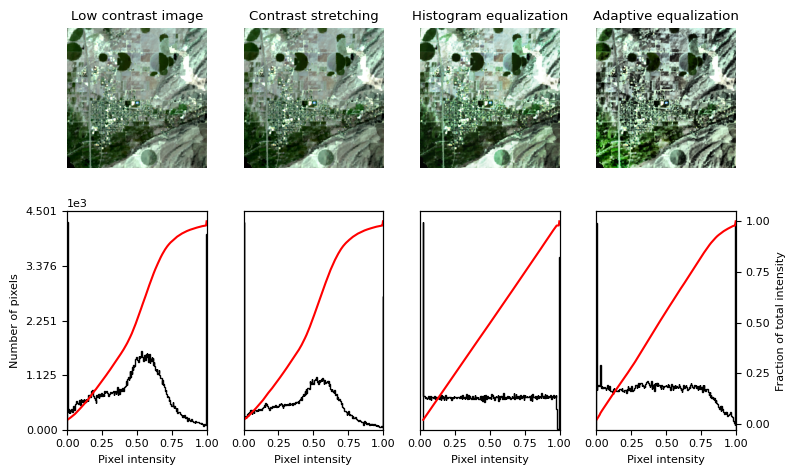

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np




matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


im = iter(training.take(2)).next()
img = im[0].numpy()[0][:,:,0:3]+np.array([0.5,0.6,0.5])
img = normalize_satellite_image(img)
# # Load an example image
# img = data.moon()

# Contrast stretching
p2, p98 = np.percentile(img, (3, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()